## Setup

In [14]:
# ---- ENVIRONMENT SETUP ----
# Import modules
import os
import time
import random
import concurrent.futures
import numpy as np
import networkx as nx
import gurobipy as gp
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from gurobipy import Model, GRB, quicksum
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.basemap import Basemap
from numba.typed import Dict
from numba.types import unicode_type, float64

# DWave
import dimod
from dimod import BinaryQuadraticModel
from dimod.utilities import qubo_to_ising
from dwave.system import DWaveSampler, AutoEmbeddingComposite, LeapHybridSampler
from dwave.samplers import SimulatedAnnealingSampler, SteepestDescentSolver
from dwave_networkx.algorithms.coloring import min_vertex_color, is_vertex_coloring, min_vertex_color_qubo

# Import custom helpers
from src.plotting import *
from src.benchmark import *
from src.connected_network import *
from src.graph_coloring import *

# Configure numpy print options
np.set_printoptions(linewidth=200)
np.set_printoptions(precision=3, suppress=True)

# Source API token
dotenv_path = "../.env"
load_dotenv(dotenv_path)

True

# WA Benchmarks

Ensure you have a license to solve the large problems with gurobi, see [docs](https://support.gurobi.com/hc/en-us/articles/360051597492-How-do-I-resolve-a-Model-too-large-for-size-limited-Gurobi-license-error?sort_by=created_at) for more info
First we define the samplers we need:

In [15]:
sim_sampler = SimulatedAnnealingSampler()
q_sampler = AutoEmbeddingComposite(DWaveSampler(token=os.environ['DWAVE_API_TOKEN'])) # Authenticate with token
hybrid_sampler = LeapHybridSampler(token=os.environ['DWAVE_API_TOKEN'])


A bunch of hacky functions to repeat QA measurements since they usually need to be rerun

In [16]:
def custom_vertex_color(G, sampler, name, attempts=5):
    if name == 'Hybrid Annealing (HA)':
        attempts = 1

    for i in range(attempts):
        solution = min_vertex_color(G, sampler=sampler)
        try:
            if is_vertex_coloring(G, solution):
                print(f"[i] Attempts taken: {i+1}")
                return {'status': True, 'solution': solution}
        except KeyError as e:
            continue
    return {'status': False}

In [17]:
def run_gcp_annealing(G, sampler, bmark_name, name, results, status, timing_results, timeout=600):
    if status[bmark_name]:
        try:
            print(f"[i] Running {bmark_name}")
            with concurrent.futures.ThreadPoolExecutor() as executor:
                start_time = time.time()  # Start timing
                future = executor.submit(custom_vertex_color, G, sampler, bmark_name)
                try:
                    response = future.result(timeout=timeout)
                    end_time = time.time()  # End timing
                    elapsed_time = end_time - start_time  # Calculate elapsed time
                    
                    print("[i] Checking solution")
                    if response['status']:
                        solution = response['solution']
                        wavelengths = len(set(solution.values()))
                        results[bmark_name][name].append(wavelengths)
                        timing_results[bmark_name][name].append(elapsed_time)  # Record timing
                        print(f"[+] Found solution {bmark_name}")
                        return
                    else:
                        print(f"[+] No solution {bmark_name}")
                        status[bmark_name] = False
                        results[bmark_name][name].append(None)
                        timing_results[bmark_name][name].append(None)  # Record timing for invalid solution
                except concurrent.futures.TimeoutError:
                    print(f"[!] Timeout occurred when running {bmark_name}.")
                    status[bmark_name] = False
                    results[bmark_name][name].append(None)
                    timing_results[bmark_name][name].append(None)  # Record timeout as the timing
                    return
        except Exception as e:
            print(f"[!] An exception occurred: {e}")
            status[bmark_name] = False
            results[bmark_name][name].append(None)
            timing_results[bmark_name][name].append(None)  # Record None for timing on exception
    else:
        print(f"[i] Skipping {bmark_name}")
        results[bmark_name][name].append(None)
        timing_results[bmark_name][name].append(None)  # Record None for timing if status is False

In [19]:
# Timeout in seconds (q_timeout for quantum solver)
timeout = 3600
density_interval = 6

# Define the paths to the topology files
topology_files = {
    "Eurocore": "./topologies/Eurocore.txt",
    "EON": "./topologies/EON.txt",
    "ARPANet": "./topologies/ARPANet.txt",
    "UKNet": "./topologies/UKNet.txt",
    "Eurolarge": "./topologies/Eurolarge.txt",
    "USNet": "./topologies/USNet.txt"
}

## Print dataset statistics
Display statistics about the different network configurations

In [ ]:
for name, file in topology_files.items():
    print('[+] Loading network')
    network = ConnectedNetwork(file)
    chosen_pairs = []
    chosen_pairs_set = set()  # To keep track of existing paths for quick lookup
    all_pairs = None  # Initialize here to keep scope within the loop
    
    for density in np.linspace(0.1, 1, density_interval):      
        if all_pairs is None:
            # Get all pairs once since it doesn't change
            all_pairs = network.get_pairs()

        # Calculate the target number of paths to sample
        target_num_paths = int(round(density * len(all_pairs)))

        # Calculate how many more unique paths we need
        num_new_pairs_needed = target_num_paths - len(chosen_pairs)

        # Ensure we sample only unique new pairs
        remaining_pairs = [pair for pair in all_pairs if pair not in chosen_pairs_set]

        # Sample the required number of new unique pairs
        new_pairs = random.sample(remaining_pairs, num_new_pairs_needed)

        # Add the new pairs to the chosen_pairs and the set for tracking
        chosen_pairs.extend(new_pairs)
        chosen_pairs_set.update(new_pairs)
        G = network.network_to_gcp(chosen_pairs)

        print(f"{int(100*density)}\\% & {len(G.nodes())} & {len(G.edges())}\\\\")

In [20]:

# Dictionaries to store the results
results = {
    "LDF Greedy": {name: [] for name in topology_files},
    "Simulated Annealing (SA)": {name: [] for name in topology_files},
    "Quantum Annealing (QA)": {name: [] for name in topology_files},
    "Hybrid Annealing (HA)": {name: [] for name in topology_files},
    "Gurobi": {name: [] for name in topology_files}
}

timing_results = {
    "LDF Greedy": {name: [] for name in topology_files},
    "Simulated Annealing (SA)": {name: [] for name in topology_files},
    "Quantum Annealing (QA)": {name: [] for name in topology_files},
    "Hybrid Annealing (HA)": {name: [] for name in topology_files},
    "Gurobi": {name: [] for name in topology_files}
}

# Saved data from previous runs
#results = {'LDF Greedy': {'Eurocore': [2, 3, 4, 4, 4, 4], 'EON': [5, 11, 18, 21, 28, 37], 'ARPANet': [6, 13, 19, 26, 31, 33], 'UKNet': [4, 12, 16, 23, 27, 32], 'Eurolarge': [11, 28, 44, 60, 74, 89], 'USNet': [15, 36, 57, 77, 98, 109]}, 'Simulated Annealing (SA)': {'Eurocore': [2, 3, 4, 4, 4, 5], 'EON': [5, 13, 20, 24, 33, 42], 'ARPANet': [6, 14, 21, 28, 37, 43], 'UKNet': [5, 12, 19, 28, 34, 45], 'Eurolarge': [13, 33, 58, 80, 102, 121], 'USNet': [23, 56, 95, 130, 167, 203]}, 'Quantum Annealing (QA)': {'Eurocore': [2, 3, 4, None, None, None], 'EON': [5, None, None, None, None, None], 'ARPANet': [None, None, None, None, None, None], 'UKNet': [5, None, None, None, None, None], 'Eurolarge': [None, None, None, None, None, None], 'USNet': [None, None, None, None, None, None]}, 'Hybrid Annealing (HA)': {'Eurocore': [2, 3, 4, 4, 4, 4], 'EON': [5, 11, 18, 21, 29, 38], 'ARPANet': [6, 13, 19, 26, 33, 38], 'UKNet': [4, 12, 16, 24, 28, 38], 'Eurolarge': [11, 28, 46, 65, None, None], 'USNet': [17, 42, 70, None, None, None]}, 'Gurobi': {'Eurocore': [2, 3, 4, 4, 4, 4], 'EON': [5, 11, 18, None, None, None], 'ARPANet': [6, 13, 19, None, None, None], 'UKNet': [4, 12, 16, None, None, None], 'Eurolarge': [11, None, None, None, None, None], 'USNet': [None, None, None, None, None, None]}}
#timing_results = {'LDF Greedy': {'Eurocore': [0.0007166862487792969, 0.0007143020629882812, 0.0007650852203369141, 0.0009217262268066406, 0.001294851303100586, 0.0008759498596191406], 'EON': [0.0007264614105224609, 0.0009083747863769531, 0.001157522201538086, 0.0011861324310302734, 0.0017445087432861328, 0.0020165443420410156], 'ARPANet': [0.0010170936584472656, 0.000997304916381836, 0.0010833740234375, 0.001401662826538086, 0.0017938613891601562, 0.0022475719451904297], 'UKNet': [0.0006997585296630859, 0.0009784698486328125, 0.0011110305786132812, 0.001270294189453125, 0.0016613006591796875, 0.00200653076171875], 'Eurolarge': [0.0014934539794921875, 0.0022389888763427734, 0.003992319107055664, 0.0076711177825927734, 0.011326789855957031, 0.015243291854858398], 'USNet': [0.0011382102966308594, 0.003104686737060547, 0.006581783294677734, 0.011180639266967773, 0.017328500747680664, 0.0256803035736084]}, 'Simulated Annealing (SA)': {'Eurocore': [0.00419163703918457, 0.006940364837646484, 0.012001991271972656, 0.014662504196166992, 0.03954505920410156, 0.042456865310668945], 'EON': [0.012387990951538086, 0.17037296295166016, 0.46639037132263184, 0.9218380451202393, 2.2103872299194336, 4.098059892654419], 'ARPANet': [0.016920089721679688, 0.1683506965637207, 0.5605952739715576, 1.2899150848388672, 2.688638687133789, 4.4152445793151855], 'UKNet': [0.014393091201782227, 0.19302821159362793, 0.47388792037963867, 1.3619966506958008, 2.626384973526001, 4.677668809890747], 'Eurolarge': [0.24923968315124512, 4.680620908737183, 16.047856092453003, 43.999629497528076, 95.43810319900513, 351.5215675830841], 'USNet': [0.9212324619293213, 13.073978662490845, 47.98550748825073, 130.74581694602966, 276.080881357193, 537.2329792976379]}, 'Quantum Annealing (QA)': {'Eurocore': [3.1450579166412354, 3.258488893508911, 2.4090874195098877, None, None, None], 'EON': [4.846871614456177, None, None, None, None, None], 'ARPANet': [None, None, None, None, None, None], 'UKNet': [8.53482437133789, None, None, None, None, None], 'Eurolarge': [None, None, None, None, None, None], 'USNet': [None, None, None, None, None, None]}, 'Hybrid Annealing (HA)': {'Eurocore': [8.826599836349487, 10.696306943893433, 9.774385213851929, 9.454128742218018, 9.712085723876953, 10.122413873672485], 'EON': [13.838568210601807, 14.013139486312866, 20.032668828964233, 42.60013151168823, 70.32476210594177, 123.74493384361267], 'ARPANet': [11.891682147979736, 13.691657781600952, 21.38747763633728, 38.385547161102295, 75.56773805618286, 145.40564846992493], 'UKNet': [32.92565131187439, 11.849545240402222, 21.69459819793701, 80.2101616859436, 97.66300654411316, 153.85531067848206], 'Eurolarge': [14.690821170806885, 185.47802424430847, 494.56069684028625, 761.7731790542603, None, None], 'USNet': [26.010748863220215, 332.30825424194336, 698.7957952022552, None, None, None]}, 'Gurobi': {'Eurocore': [0.019063949584960938, 0.031958818435668945, 0.07469844818115234, 0.2864208221435547, 0.5018229484558105, 2.3907580375671387], 'EON': [0.07636499404907227, 16.209545373916626, 116.61649537086487, None, None, None], 'ARPANet': [0.06791114807128906, 21.932536840438843, 2198.902702331543, None, None, None], 'UKNet': [0.08874344825744629, 42.14949440956116, 3251.8215477466583, None, None, None], 'Eurolarge': [157.3982846736908, None, None, None, None, None], 'USNet': [None, None, None, None, None, None]}}

# Loop through each topology, generate the graph, and run the benchmarks
for name, file in topology_files.items():
    print('[+] Loading network')
    network = ConnectedNetwork(file)
    status = {name: True for name in results.keys()}
    chosen_pairs = []
    chosen_pairs_set = set()  # To keep track of existing paths for quick lookup
    all_pairs = None  # Initialize here to keep scope within the loop
    
    for density in np.linspace(0.1, 1, density_interval):      
        if all_pairs is None:
            # Get all pairs once since it doesn't change
            all_pairs = network.get_pairs()

        # Calculate the target number of paths to sample
        target_num_paths = int(round(density * len(all_pairs)))

        # Calculate how many more unique paths we need
        num_new_pairs_needed = target_num_paths - len(chosen_pairs)

        # Ensure we sample only unique new pairs
        remaining_pairs = [pair for pair in all_pairs if pair not in chosen_pairs_set]

        # Sample the required number of new unique pairs
        new_pairs = random.sample(remaining_pairs, num_new_pairs_needed)

        # Add the new pairs to the chosen_pairs and the set for tracking
        chosen_pairs.extend(new_pairs)
        chosen_pairs_set.update(new_pairs)
        G = network.network_to_gcp(chosen_pairs)
        #display_graph(G)

        print(f"[+] Solving {name} Network with density {density} (nodes: {len(G.nodes())}, edges: {len(G.edges())})")
        
        # ---- QUANTUM ANNEALING ----
        bmark_name = "Quantum Annealing (QA)"
        run_gcp_annealing(G, q_sampler, bmark_name, name, results, status, timing_results, timeout)

        # ---- LDF HEURISTIC ----
        bmark_name = "LDF Greedy"
        print(f"[i] Running {bmark_name}                  ", end="\r")
        if status[bmark_name]:
            result = benchmark_coloring(bmark_name, solve_graph_coloring_networkx, timeout, G)
            if result is None:
                status[bmark_name] = False
                results[bmark_name][name].append(None)
                timing_results[bmark_name][name].append(None)
            else:
                print(result)
                results[bmark_name][name].append(result[0])
                timing_results[bmark_name][name].append(result[1])
        else:
            results[bmark_name][name].append(None)
            timing_results[bmark_name][name].append(None)

        # ---- SIMULATED ANNEALING ----
        bmark_name = "Simulated Annealing (SA)"
        print(f"[i] Running {bmark_name}                  ", end="\r")
        if status[bmark_name]:
            result = benchmark_coloring(bmark_name, solve_graph_coloring_annealing, timeout, G, sampler=sim_sampler)
            if result is None:
                status[bmark_name] = False
                results[bmark_name][name].append(None)
                timing_results[bmark_name][name].append(None)
            else:
                results[bmark_name][name].append(result[0])
                timing_results[bmark_name][name].append(result[1])
        else:
            results[bmark_name][name].append(None)
            timing_results[bmark_name][name].append(None)

        # ---- GUROBI ----
        bmark_name = "Gurobi"
        print(f"[i] Running {bmark_name}                  ", end="\r")
        if status[bmark_name]:
            result = benchmark_coloring(bmark_name, solve_graph_coloring_gurobi, timeout, G)
            if result is None:
                status[bmark_name] = False
                results[bmark_name][name].append(None)
                timing_results[bmark_name][name].append(None)
            else:
                results[bmark_name][name].append(result[0])
                timing_results[bmark_name][name].append(result[1])
        else:
            results[bmark_name][name].append(None)
            timing_results[bmark_name][name].append(None)

        # ---- HYBRID ANNEALING ----
        # Run benchmark and return the number of colors used for solving GCP
        bmark_name = "Hybrid Annealing (HA)"
        run_gcp_annealing(G, hybrid_sampler, bmark_name, name, results, status, timing_results, timeout)

        #time.sleep(10)
        print("RESULTS")
        print(results)
        print("TIMINGS")
        print(timing_results)

[+] Loading network
[+] Solving USNet Network with density 0.1 (nodes: 207, edges: 2059)
[i] Running Quantum Annealing (QA)
[!] An exception occurred: no embedding found
[15, 0.0011382102966308594]             
Set parameter WLSAccessID                             
Set parameter WLSSecret
Set parameter LicenseID to value 2539199
Academic license 2539199 - for non-commercial use only - registered to vi___@ucl.ac.uk
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Arch Linux")

CPU model: AMD Ryzen 9 5900HX with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Academic license 2539199 - for non-commercial use only - registered to vi___@ucl.ac.uk
Optimize a model with 426626 rows, 43056 columns and 1321900 nonzeros
Model fingerprint: 0x595089cd
Variable types: 0 continuous, 43056 integer (43056 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Boun

# Plotting results

In [21]:
# Define a function to plot the results and timing results in a 3x4 grid
def plot_coloring_bmark_results(results, timing_results, label_1, label_2, label_3, density_interval, topology_files):
    densities = np.linspace(0.1, 1, density_interval)
    markers = ['o', 's', '^', 'D', 'x', '*']  # Circle, Square, Triangle, Diamond, x, Star
    colors = ['orange', 'darkred', 'green', 'black', 'blue', 'blue']
    fill_styles = ['full', 'none', 'full', 'none', 'none', 'none']  # Different fill styles

    # Create a 3x4 grid
    fig, axs = plt.subplots(3, 4, figsize=(24, 12))  # Adjusted figsize for more space
    axs = axs.flatten()  # Flatten the 2D array of axes to make it easier to iterate

    for idx, name in enumerate(topology_files):
        # Plot the results on the left side (first two columns)
        ax_result = axs[idx * 2]
        for (solver, color_list), marker, color, fill in zip(results.items(), markers, colors, fill_styles):
            valid_densities = [densities[i] for i in range(density_interval) if color_list[name][i] is not None]
            valid_results = [color_list[name][i] for i in range(density_interval) if color_list[name][i] is not None]
            ax_result.plot(valid_densities, valid_results, marker=marker, color=color, label=solver,
                           markerfacecoloralt=color, fillstyle=fill, markersize=8)
        
        ax_result.set_title(f"{name} WA Results", fontsize=16)
        ax_result.set_xlabel(label_1, fontsize=14)
        ax_result.set_ylabel(label_2, fontsize=14)
        ax_result.grid(True, linestyle='--', alpha=0.7)
        ax_result.yaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure integer y-axis

        # Plot the timing results on the right side (last two columns)
        ax_timing = axs[idx * 2 + 1]
        for (solver, timing_list), marker, color, fill in zip(timing_results.items(), markers, colors, fill_styles):
            valid_densities = [densities[i] for i in range(density_interval) if timing_list[name][i] is not None]
            valid_timings = [timing_list[name][i] for i in range(density_interval) if timing_list[name][i] is not None]
            ax_timing.plot(valid_densities, valid_timings, marker=marker, color=color, label=solver,
                           markerfacecoloralt=color, fillstyle=fill, markersize=8)
        
        ax_timing.set_title(f"{name} Timing Results", fontsize=16)
        ax_timing.set_xlabel(label_1, fontsize=14)
        ax_timing.set_ylabel(label_3, fontsize=14)
        ax_timing.grid(True, linestyle='--', alpha=0.7)
        ax_timing.set_yscale('log')  # Ensure exponential y-axis

    # Generate a combined legend from the results subplots (left side)
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1), ncol=5, fontsize=16, fancybox=True, edgecolor='black')

    # Adjust the spacing between subplots
    fig.subplots_adjust(wspace=0.45, hspace=0.35)  # Increase hspace for more vertical space
    x_position = 0.4995  # Position of the line between 2nd and 3rd columns
    fig.add_artist(plt.Line2D([x_position, x_position], [0, 0.95], transform=fig.transFigure, color='black', linestyle='--'))

    # Adjust layout to make room for the legend
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

{'LDF Greedy': {'Eurocore': [2, 3, 4, 4, 4, 4], 'EON': [5, 11, 18, 21, 28, 37], 'ARPANet': [6, 13, 19, 26, 31, 33], 'UKNet': [4, 12, 16, 23, 27, 32], 'Eurolarge': [11, 28, 44, 60, 74, 89], 'USNet': [15, 36, 57, 77, 98, 109]}, 'Simulated Annealing (SA)': {'Eurocore': [2, 3, 4, 4, 4, 5], 'EON': [5, 13, 20, 24, 33, 42], 'ARPANet': [6, 14, 21, 28, 37, 43], 'UKNet': [5, 12, 19, 28, 34, 45], 'Eurolarge': [13, 33, 58, 80, 102, 121], 'USNet': [23, 56, 95, 130, 167, 203]}, 'Quantum Annealing (QA)': {'Eurocore': [2, 3, 4, None, None, None], 'EON': [5, None, None, None, None, None], 'ARPANet': [None, None, None, None, None, None], 'UKNet': [5, None, None, None, None, None], 'Eurolarge': [None, None, None, None, None, None], 'USNet': [None, None, None, None, None, None]}, 'Hybrid Annealing (HA)': {'Eurocore': [2, 3, 4, 4, 4, 4], 'EON': [5, 11, 18, 21, 29, 38], 'ARPANet': [6, 13, 19, 26, 33, 38], 'UKNet': [4, 12, 16, 24, 28, 38], 'Eurolarge': [11, 28, 46, 65, None, None], 'USNet': [17, 42, 70, None

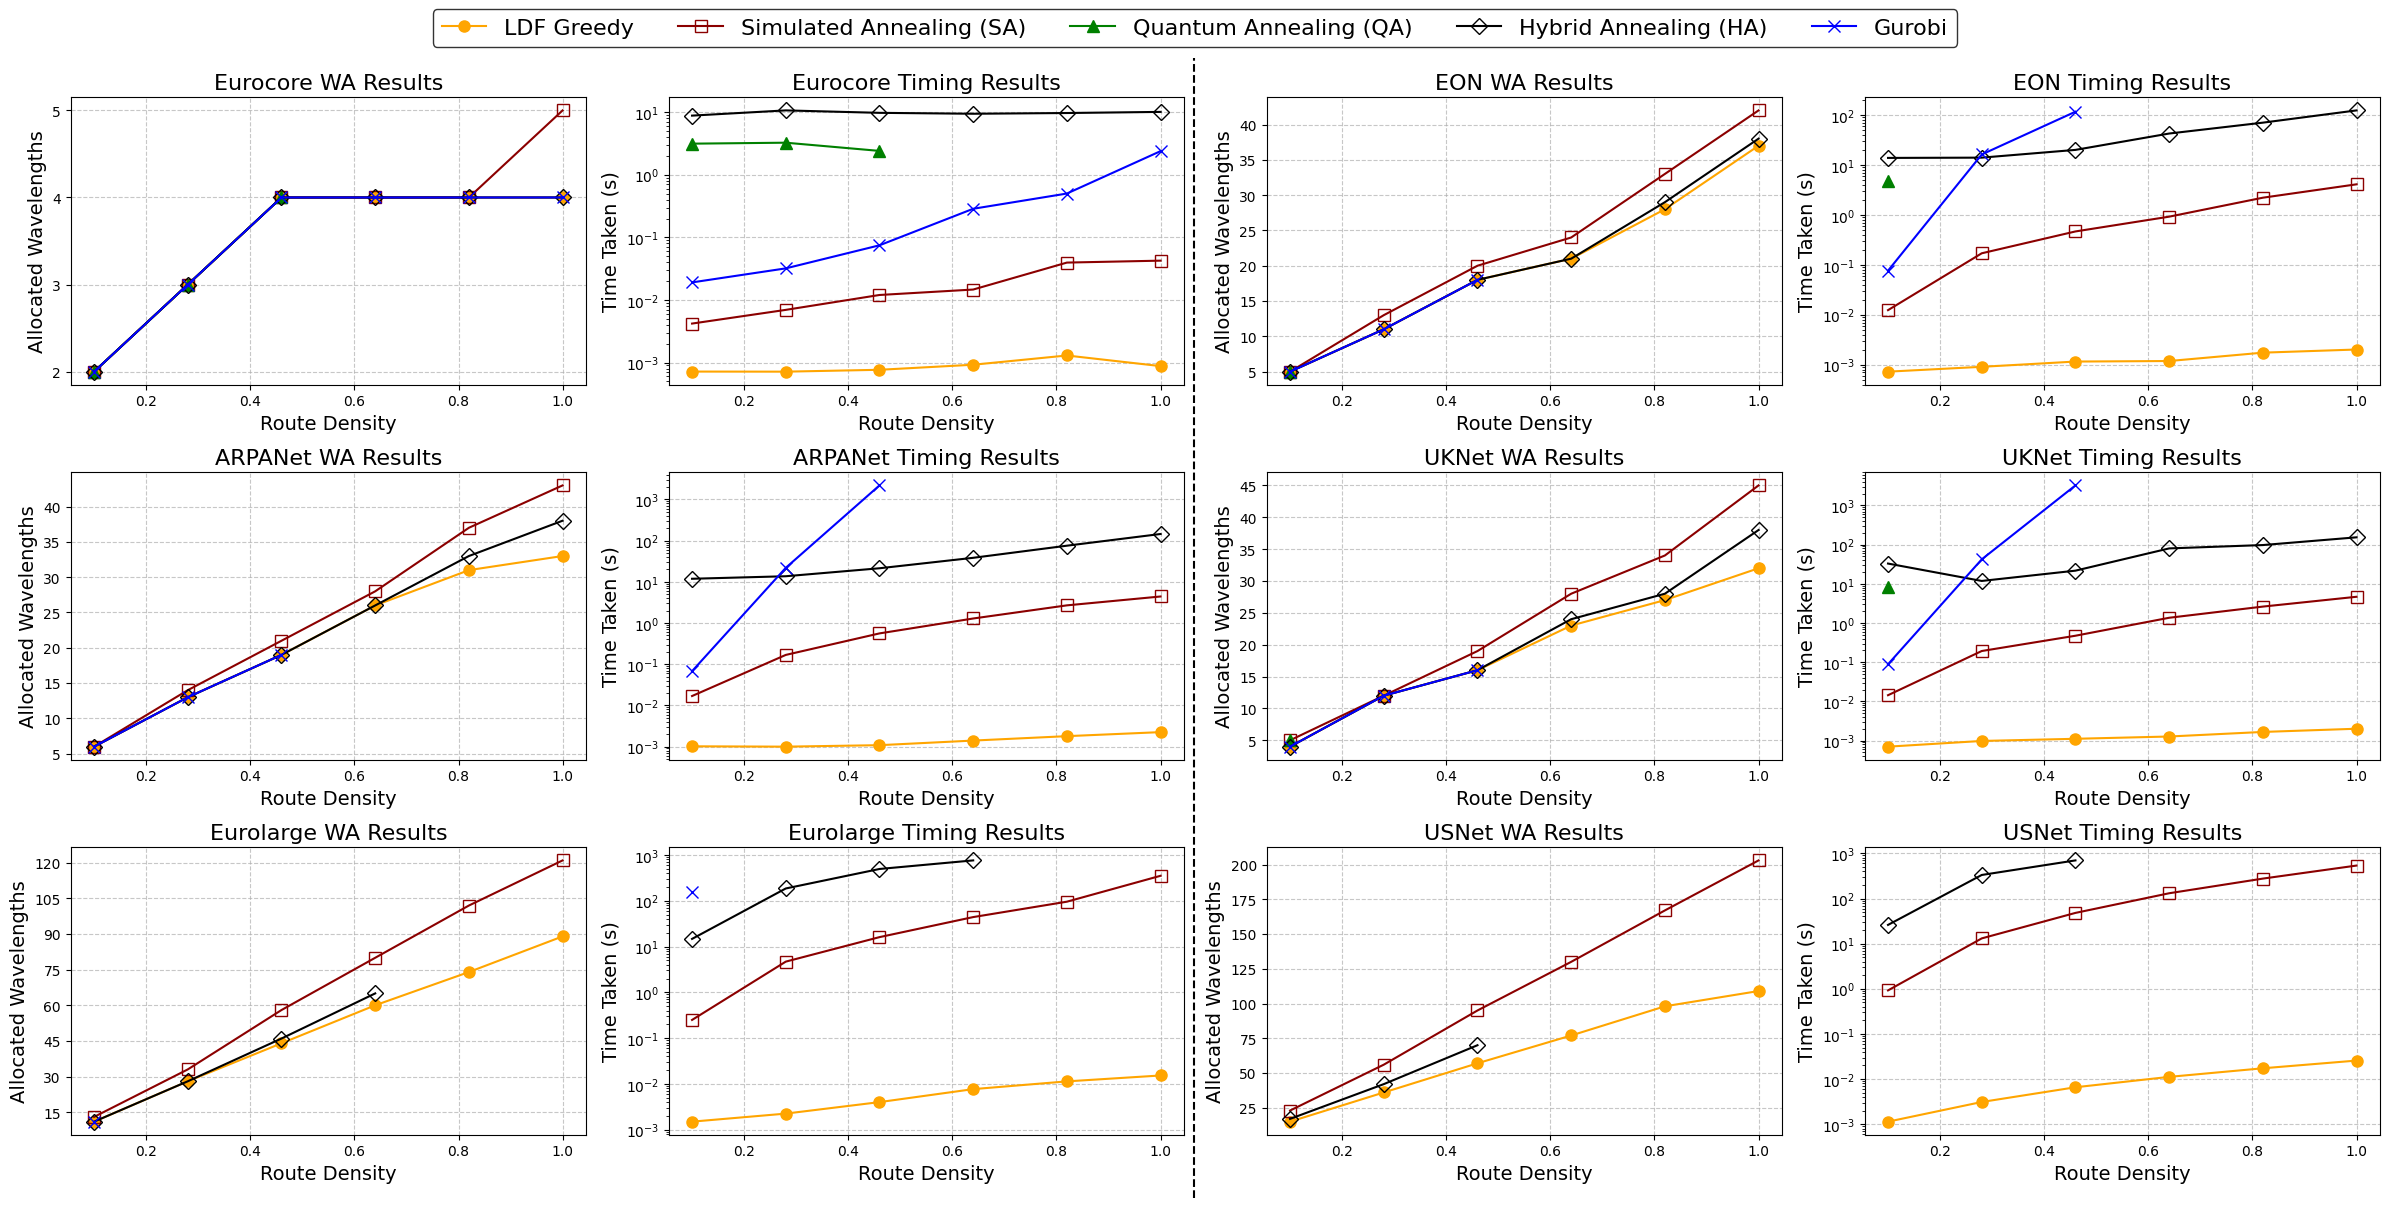

In [22]:
# Plot the results for each topology
# Define the paths to the topology files
topology_files = {
    "Eurocore": "../other/selected_topologies/Eurocore.txt",
    "EON": "../other/selected_topologies/EON.txt",
    "ARPANet": "../other/selected_topologies/ARPANet.txt",
    "UKNet": "../other/selected_topologies/UKNet.txt",
    "Eurolarge": "../other/selected_topologies/Eurolarge.txt",
    "USNet": "../other/selected_topologies/USNet.txt"
}

print(results)
print(timing_results)
plot_coloring_bmark_results(results, timing_results, "Route Density", "Allocated Wavelengths", "Time Taken (s)", density_interval, topology_files)

# RWA QUBO Formulation
First, we plot the toy problem graph

[+] DEBUG: Setting seed for plotting position 1356805582


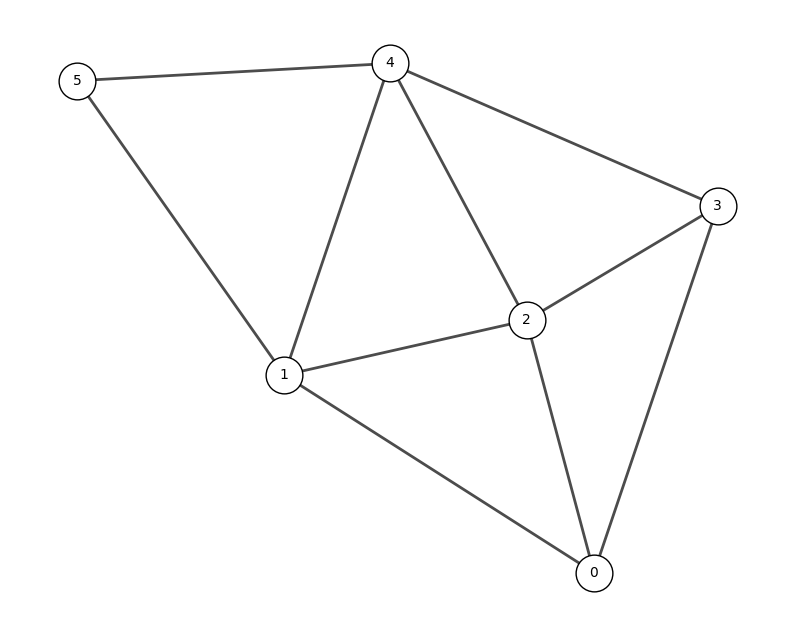

In [12]:
# Create an instance of ConnectedNetwork
toy_problem = ConnectedNetwork("../other/selected_topologies/toygraph.txt")
display_graph(toy_problem.get_graph())

Now we generate the actual graph we're trying to solve for. It includes the link overlap relations between all precomputed best routes for each node pair in the initial graph, encoded as edges. 

[+] DEBUG: Setting seed for plotting position 3404852316


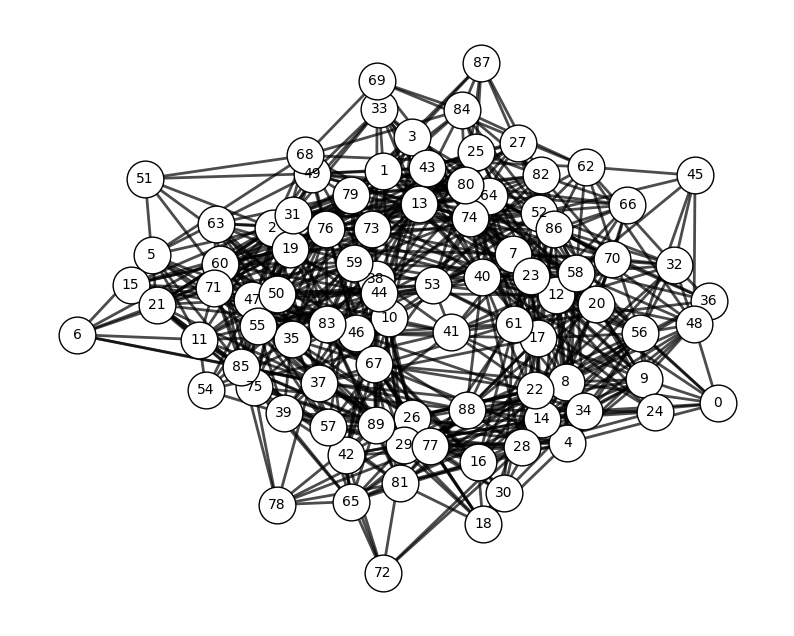

[i] Total route count (transformed): 90
[i] Total edge count (transformed): 694


In [19]:
routing_graph, reverse_mapping = toy_problem.build_routing_graph()
max_hops = toy_problem.get_max_hops(reverse_mapping)
display_graph(routing_graph)
print(f"[i] Total route count (transformed): {len(routing_graph.nodes())}")
print(f"[i] Total edge count (transformed): {len(routing_graph.edges())}")

## Solve QUBO for transformed graph

In [14]:
def get_histogram_data(sampler, reruns=5):
    # Parameters for the QUBO
    counts = [0, 0, 0]
    c1, c2, c3, c4 = [0, 16.5, 0, -4]  # Optimized with grid search
    num_reads = 20
    successes = 0

    for i in range(reruns):
        sampleset, pair_routes, reverse_mapping, solved_G = toy_problem.solve_qubo(c1, c2, c3, c4, num_runs=num_reads, sampler=sampler)
        #print(sampleset.info["timing"]) 

        # Collect data
        for sample in sampleset.samples():
            if ConnectedNetwork.check_solution(sample, pair_routes, reverse_mapping):
                successes += 1
                for k, v in sample.items():
                    if v == 1:
                        counts[k % 3] += 1
        # Solve the QUBO
        success_rate = successes/(num_reads * (i+1))
        print(f"[i] Run {i+1}/{reruns} (successes: {successes}, rate: {success_rate}, counts: {counts})                 ", end="\r")

    print()
    return counts, success_rate

In [8]:
# ACCUMULATED PROGRESS FROM PREVIOUS RUNS (avoids costly reruns if data is lost)
# Simulations are run over 40000 results
sim_counts = [1029057, 140794, 28049]
sim_rate = 0.99825

# Quantum runs
q_counts = [1170, 129, 51]
q_rate = 45 / (20 * 71)

# Hybrid runs
hybrid_counts = [1016, 113, 41]
hybrid_rate = 39 / (20*58)

## Plot Histogram

In [12]:
def plot_combined_histogram(sim_counts, q_counts, hybrid_counts, labels):
    # Calculate percentages for each set of counts
    sim_percentages = [x / sum(sim_counts) * 100 for x in sim_counts]
    q_percentages = [x / sum(q_counts) * 100 for x in q_counts]
    hybrid_percentages = [x / sum(hybrid_counts) * 100 for x in hybrid_counts]

    # Data for histogram
    categories = ['Least Hops (Best) Route', 'Second Best Route', 'Third Best Route']
    x = np.arange(len(categories))

    # Width and positions for grouped bars
    bar_width = 0.25
    x_sim = x - bar_width
    x_q = x
    x_hybrid = x + bar_width

    # Plot histogram with enhanced y-axis and grid lines
    plt.figure(figsize=(10, 6))
    bars_sim = plt.bar(x_sim, sim_percentages, width=bar_width, color='skyblue', label='Simulated Annealing (SA)')
    bars_q = plt.bar(x_q, q_percentages, width=bar_width, color='orange', label='Quantum Annealing (QA)')
    bars_hybrid = plt.bar(x_hybrid, hybrid_percentages, width=bar_width, color='green', label='Hybrid Annealing (HA)')

    # Set labels and title
    plt.xticks(x, categories, fontsize=11)
    plt.ylabel('Selection Frequency (%)', fontsize=15)
    plt.title('Selected Routes by Hop Count', fontsize=16)
    plt.ylim(0, max(sim_percentages + q_percentages + hybrid_percentages) + 10)
    plt.yticks(range(0, 101, 10))
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add legend
    plt.legend()

    plt.show()

[+] Simulated Annealing success rate: 99.825%
[+] Quantum Annealing success rate: 3.169014084507042%
[+] Hybrid Solver success rate: 3.362068965517241%


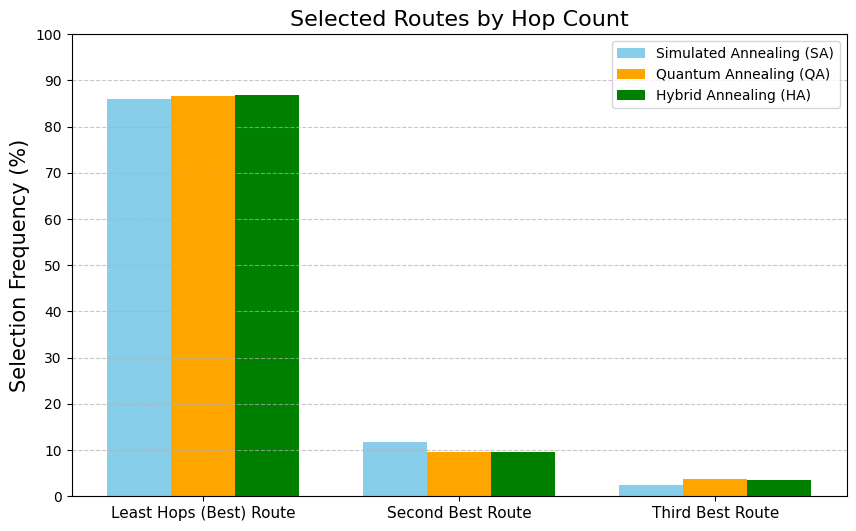

In [13]:
print(f"[+] Simulated Annealing success rate: {sim_rate*100}%")
print(f"[+] Quantum Annealing success rate: {q_rate*100}%")
print(f"[+] Hybrid Solver success rate: {hybrid_rate*100}%")

# Labels for the datasets
labels = ['Simulated Annealing (SA)', 'Quantum Annealing (QA)', 'Hybrid Annealing (HA)']

plot_combined_histogram(sim_counts, q_counts, hybrid_counts, labels)

# TODO add wavelength benchmark for GCP

## Solve the QUBO formulation to get new routing graph

After that, plot the solution graph subset and do GCP using Simulated Annealing and plot the result of that too.

In [ ]:
# Parameters for the QUBO
c1, c2, c3, c4 = [0, 16.5, 0, -4]  # Optimized with grid search
num_reads = 20

while True:
    # Solve the QUBO on Simulated Annealing
    sampleset, pair_routes, reverse_mapping, solved_G = toy_problem.solve_qubo(c1, c2, c3, c4, num_runs=num_reads, sampler=sim_sampler)
    sample = sampleset.samples()[0]
    if ConnectedNetwork.check_solution(sample, pair_routes, reverse_mapping):
        print("[+] Solved!")
        for k, v in sample.items():
            if v == 0:
                solved_G.remove_node(k)
        break
    print("[-] No solution found")

seed = 4
display_graph(solved_G, seed)
print(f"[+] Total routes: {len(solved_G.nodes())}")

# Create the QUBO problem and solve it
while True:
    print("Running")
    solution = min_vertex_color(solved_G, sampler=q_sampler)
    if is_vertex_coloring(solved_G, solution):
        plot_colored_solution(solved_G, solution, seed)
        break

## QUANTUM SAMPLER, DO NOT RUN ACCIDENTALLY (I'm too broke to waste QPU compute time)

In [ ]:
# Parameters for the QUBO
c1, c2, c3, c4 = [0, 16.5, 0, -4]  # Optimized with grid search
num_reads = 20

# Solve the QUBO on Simulated Annealing
sampleset, pair_routes, reverse_mapping, solved_G = toy_problem.solve_qubo(c1, c2, c3, c4, num_runs=num_reads, sampler=q_sampler)

In [ ]:
solutions = 0

outcomes = []
for sample in sampleset.samples():
    altered_G = solved_G.copy()
    status = False
    if ConnectedNetwork.check_solution(sample, pair_routes, reverse_mapping):
        print(sample)
        print("[+] Solved!")
        solutions += 1
        status = True
        for k, v in sample.items():
            if v == 0:
                altered_G.remove_node(k)
    else:
        print("[-] No solution found")
    outcomes.append({
            "graph": altered_G,
            "status": status
        })

print(f"[+] Success rate: {solutions/num_reads*100}%")

In [ ]:
seed = 4

for outcome in outcomes:
    # Create the QUBO problem and solve it
    if outcome['status']:
        display_graph(outcome['graph'], seed)
        print(f"[+] Total routes: {len(outcome['graph'].nodes())}")
        solution = min_vertex_color(outcome['graph'], sampler=q_sampler)
        if is_vertex_coloring(outcome['graph'], solution):
            plot_colored_solution(outcome['graph'], solution, seed)
            break